In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from io import StringIO
import warnings
import re

In [4]:
#Read in data
mvp = pd.read_csv("/Users/kaydenvandecaveye/NBA MVP Project/Historic-MVP-Data.csv")
standings = pd.read_csv("/Users/kaydenvandecaveye/NBA MVP Project/Historic-Standings-Data.csv")
players = pd.read_csv("/Users/kaydenvandecaveye/NBA MVP Project/Historic-Player-Data.csv")

In [5]:
mvp = mvp[["Player","Pts Won","Year","Pts Max","Share"]]
mvp

,Player,Pts Won,Year,Pts Max,Share
0,Kareem Abdul-Jabbar,147.0,1980,221,0.665
1,Julius Erving,31.5,1980,221,0.143
2,George Gervin,19.0,1980,221,0.086
3,Larry Bird,15.0,1980,221,0.068
4,Tiny Archibald,2.0,1980,221,0.009
...,...,...,...,...,...
714,Jalen Brunson,142.0,2024,990,0.143
715,Jayson Tatum,86.0,2024,990,0.087
716,Anthony Edwards,18.0,2024,990,0.018
717,Domantas Sabonis,3.0,2024,990,0.003


In [6]:
players

,Unnamed: 0,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year
0,0,1,Kareem Abdul-Jabbar*,C,32,LAL,82,NaN,38.3,10.2,...,2.3,8.5,10.8,4.5,1.0,3.4,3.6,2.6,24.8,1980
1,1,2,Tom Abernethy,PF,25,GSW,67,NaN,18.2,2.3,...,0.9,1.9,2.9,1.3,0.5,0.2,0.6,1.8,5.4,1980
2,2,3,Alvan Adams,C,25,PHO,75,NaN,28.9,6.2,...,2.1,6.0,8.1,4.3,1.4,0.7,2.9,3.2,14.9,1980
3,3,4,Tiny Archibald*,PG,31,BOS,80,80,35.8,4.8,...,0.7,1.7,2.5,8.4,1.3,0.1,3.0,2.7,14.1,1980
4,4,5,Dennis Awtrey,C,31,CHI,26,6,21.5,1.0,...,1.1,3.3,4.4,1.5,0.5,0.6,1.0,2.5,3.3,1980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24777,757,568,Thaddeus Young,PF,35,PHO,10,0,8.9,1.1,...,1.7,1.1,2.8,0.7,0.5,0.2,0.4,1.1,2.3,2024
24778,758,569,Trae Young,PG,25,ATL,54,54,36.0,8.0,...,0.4,2.3,2.8,10.8,1.3,0.2,4.4,2.0,25.7,2024
24779,759,570,Omer Yurtseven,C,25,UTA,48,12,11.4,2.1,...,1.5,2.8,4.3,0.6,0.2,0.4,0.8,1.1,4.6,2024
24780,760,571,Cody Zeller,C,31,NOP,43,0,7.4,0.6,...,1.1,1.5,2.6,0.9,0.2,0.1,0.4,1.0,1.8,2024


In [7]:
#Clean players data
players["Player"] = players["Player"].str.replace("*","",regex = False)
del players["Unnamed: 0"]
del players["Rk"]

In [8]:
players.groupby(["Player","Year"])
groups = players.groupby(["Player","Year"])

In [9]:
#Change players who played on multiple teams in a season to their total stats on their final team for the season
def single_row(df):
    if df.shape[0] == 1:
        return df
    else:
        last_team = df.iloc[-1]["Tm"]
        for index, row in df.iterrows():
            if row["Tm"] == "TOT":
                df.at[index, "Tm"] = last_team
        return df[df["Tm"] == last_team]
players = players.groupby(["Player","Year"]).apply(single_row)

/var/folders/hp/whvpr66n5rv6gzhr1x3vyqp40000gn/T/ipykernel_61702/2026268900.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  players = players.groupby(["Player","Year"]).apply(single_row)


In [10]:
players

Player Pos Age   Tm   G  GS    MP   FG  \
Player         Year                                                         
A.C. Green     1986 2388       A.C. Green  PF  22  LAL  82   1  18.8  2.5   
               1987 2787       A.C. Green  PF  23  LAL  79  72  28.4  4.0   
               1988 3189       A.C. Green  PF  24  LAL  82  64  32.1  3.9   
               1989 3638       A.C. Green  PF  25  LAL  82  82  30.6  4.9   
               1990 4100       A.C. Green  PF  26  LAL  82  82  33.0  4.7   
...                                   ...  ..  ..  ...  ..  ..   ...  ...   
Željko Rebrača 2003 11026  Željko Rebrača   C  30  DET  30  12  16.3  2.7   
               2004 11607  Željko Rebrača   C  31  ATL  24   2  11.4  1.4   
                    11609  Željko Rebrača   C  31  ATL   3   0  17.0  4.0   
               2005 12207  Željko Rebrača   C  32  LAC  58   2  16.0  2.3   
               2006 12801  Željko Rebrača   C  33  LAC  29   2  14.2  1.8   

                           FGA   FG%  ...  ORB  DRB  TRB  AST  STL  BLK  TOV  \
Player         Year                   ...                                      
A.C. Green     1986 2388   4.7  .539  ...  2.0  2.7  4.6  0.7  0.6  0.6  1.2   
               1987 2787   7.4  .538  ...  2.7  5.1  7.8  1.1  0.9  1.0  1.3   
               1988 3189   7.8  .503  ...  3.0  5.7  8.7  1.1  1.1  0.5  1.5   
               1989 3638   9.2  .529  ...  3.1  5.9  9.0  1.3  1.1  0.7  1.5   
               1990 4100   9.8  .478  ...  3.2  5.5  8.7  1.1  0.8  0.6  1.4   
...                        ...   ...  ...  ...  ...  ...  ...  ...  ...  ...   
Željko Rebrača 2003 11026  4.8  .552  ...  0.9  2.2  3.1  0.3  0.2  0.6  1.0   
               2004 11607  3.2  .442  ...  1.0  1.5  2.4  0.3  0.2  0.5  0.7   
                    11609  7.7  .522  ...  1.3  1.7  3.0  0.7  0.0  0.7  1.3   
               2005 12207  4.0  .568  ...  0.8  2.3  3.2  0.4  0.2  0.7  0.8   
               2006 12801  3.3  .542  ...  0.4  1.8  2.2  0.3  0.2  0.7  0.8   

                            PF   PTS  Year  
Player         Year                         
A.C. Green     1986 2388   2.8   6.4  1986  
               1987 2787   2.2  10.8  1987  
               1988 3189   2.5  11.4  1988  
               1989 3638   2.1  13.3  1989  
               1990 4100   2.5  12.9  1990  
...                        ...   ...   ...  
Željko Rebrača 2003 11026  2.6   6.6  2003  
               2004 11607  2.2   3.8  2004  
                    11609  2.3   8.3  2004  
               2005 12207  2.2   5.8  2005  
               2006 12801  2.0   4.7  2006  

[22442 rows x 30 columns]

In [11]:
players.index = players.index.droplevel()

In [12]:
players.index = players.index.droplevel()

In [13]:
players[players["Tm"] == "TOT"]

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year


In [14]:
#Merge MVP and Players DFs
players_combined = players.merge(mvp, how = "outer", on = ["Year","Player"])
players_combined

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,AST,STL,BLK,TOV,PF,PTS,Year,Pts Won,Pts Max,Share
0,Abdul Jeelani,SF,25,POR,77,NaN,16.7,3.7,7.3,.510,...,1.2,0.5,0.5,1.5,2.0,9.6,1980,NaN,NaN,NaN
1,Adrian Dantley,SF,24,UTA,68,NaN,39.3,10.7,18.6,.576,...,2.8,1.4,0.2,3.4,3.1,28.0,1980,NaN,NaN,NaN
2,Al Skinner,SG,27,PHI,2,0,5.0,0.5,1.0,.500,...,1.0,0.0,0.0,1.0,0.5,1.0,1980,NaN,NaN,NaN
3,Alex English,SF,26,DEN,78,NaN,30.8,7.1,14.3,.497,...,2.9,0.9,0.8,2.7,2.6,16.9,1980,NaN,NaN,NaN
4,Alex English,SF,26,DEN,24,NaN,36.5,8.6,17.8,.485,...,3.4,1.2,1.2,3.8,3.3,21.3,1980,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22437,Zach LaVine,SG,28,CHI,25,23,34.9,6.8,15.0,.452,...,3.9,0.8,0.3,2.1,2.3,19.5,2024,NaN,NaN,NaN
22438,Zavier Simpson,PG,26,MEM,7,0,23.0,2.4,7.7,.315,...,3.6,1.0,0.4,1.4,1.6,6.0,2024,NaN,NaN,NaN
22439,Zeke Nnaji,PF,23,DEN,58,0,9.9,1.2,2.6,.463,...,0.6,0.3,0.7,0.5,1.4,3.2,2024,NaN,NaN,NaN
22440,Ziaire Williams,SF,22,MEM,51,15,20.4,2.9,7.4,.397,...,1.5,0.7,0.2,1.3,1.7,8.2,2024,NaN,NaN,NaN


In [15]:
players_combined[players_combined["Player"] == "LeBron James"]

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,AST,STL,BLK,TOV,PF,PTS,Year,Pts Won,Pts Max,Share
10545,LeBron James,SG,19,CLE,79,79,39.5,7.9,18.9,.417,...,5.9,1.6,0.7,3.5,1.9,20.9,2004,11.0,1230.0,0.009
11094,LeBron James,SF,20,CLE,80,80,42.4,9.9,21.1,.472,...,7.2,2.2,0.7,3.3,1.8,27.2,2005,93.0,1270.0,0.073
11626,LeBron James,SF,21,CLE,79,79,42.5,11.1,23.1,.480,...,6.6,1.6,0.8,3.3,2.3,31.4,2006,688.0,1250.0,0.550
12147,LeBron James,SF,22,CLE,78,78,40.9,9.9,20.8,.476,...,6.0,1.6,0.7,3.2,2.2,27.3,2007,183.0,1290.0,0.142
12675,LeBron James,SF,23,CLE,75,74,40.4,10.6,21.9,.484,...,7.2,1.8,1.1,3.4,2.2,30.0,2008,438.0,1260.0,0.348
13209,LeBron James,SF,24,CLE,81,81,37.7,9.7,19.9,.489,...,7.2,1.7,1.1,3.0,1.7,28.4,2009,1172.0,1210.0,0.969
13747,LeBron James,SF,25,CLE,76,76,39.0,10.1,20.1,.503,...,8.6,1.6,1.0,3.4,1.6,29.7,2010,1205.0,1230.0,0.980
14303,LeBron James,SF,26,MIA,79,79,38.8,9.6,18.8,.510,...,7.0,1.6,0.6,3.6,2.1,26.7,2011,522.0,1210.0,0.431
14857,LeBron James,SF,27,MIA,62,62,37.5,10.0,18.9,.531,...,6.2,1.9,0.8,3.4,1.5,27.1,2012,1074.0,1210.0,0.888
15397,LeBron James,PF,28,MIA,76,76,37.9,10.1,17.8,.565,...,7.3,1.7,0.9,3.0,1.4,26.8,2013,1207.0,1210.0,0.998


In [16]:
players_combined.columns

Index(['Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB',
       'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Year',
       'Pts Won', 'Pts Max', 'Share'],
      dtype='object')

In [17]:
#Remove NA's for players who were not MVP candidates
players_combined[["Pts Won","Pts Max","Share"]] = players_combined[["Pts Won","Pts Max","Share"]].fillna(0)
players_combined[players_combined["Player"] == "LeBron James"]

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,AST,STL,BLK,TOV,PF,PTS,Year,Pts Won,Pts Max,Share
10545,LeBron James,SG,19,CLE,79,79,39.5,7.9,18.9,.417,...,5.9,1.6,0.7,3.5,1.9,20.9,2004,11.0,1230.0,0.009
11094,LeBron James,SF,20,CLE,80,80,42.4,9.9,21.1,.472,...,7.2,2.2,0.7,3.3,1.8,27.2,2005,93.0,1270.0,0.073
11626,LeBron James,SF,21,CLE,79,79,42.5,11.1,23.1,.480,...,6.6,1.6,0.8,3.3,2.3,31.4,2006,688.0,1250.0,0.550
12147,LeBron James,SF,22,CLE,78,78,40.9,9.9,20.8,.476,...,6.0,1.6,0.7,3.2,2.2,27.3,2007,183.0,1290.0,0.142
12675,LeBron James,SF,23,CLE,75,74,40.4,10.6,21.9,.484,...,7.2,1.8,1.1,3.4,2.2,30.0,2008,438.0,1260.0,0.348
13209,LeBron James,SF,24,CLE,81,81,37.7,9.7,19.9,.489,...,7.2,1.7,1.1,3.0,1.7,28.4,2009,1172.0,1210.0,0.969
13747,LeBron James,SF,25,CLE,76,76,39.0,10.1,20.1,.503,...,8.6,1.6,1.0,3.4,1.6,29.7,2010,1205.0,1230.0,0.980
14303,LeBron James,SF,26,MIA,79,79,38.8,9.6,18.8,.510,...,7.0,1.6,0.6,3.6,2.1,26.7,2011,522.0,1210.0,0.431
14857,LeBron James,SF,27,MIA,62,62,37.5,10.0,18.9,.531,...,6.2,1.9,0.8,3.4,1.5,27.1,2012,1074.0,1210.0,0.888
15397,LeBron James,PF,28,MIA,76,76,37.9,10.1,17.8,.565,...,7.3,1.7,0.9,3.0,1.4,26.8,2013,1207.0,1210.0,0.998


In [18]:
standings

,Unnamed: 0,W,L,W/L%,GB,PS/G,PA/G,SRS,Year,Team
0,0,61,21,.744,—,113.5,105.7,7.37,1980,Boston Celtics*
1,1,59,23,.720,2.0,109.1,104.9,4.04,1980,Philadelphia 76ers*
2,2,39,43,.476,22.0,107.0,109.5,-2.27,1980,Washington Bullets*
3,3,39,43,.476,22.0,114.0,115.1,-0.96,1980,New York Knicks
4,4,34,48,.415,27.0,108.3,109.5,-0.98,1980,New Jersey Nets
...,...,...,...,...,...,...,...,...,...,...
1424,13,50,32,.610,—,117.9,115.6,2.30,2024,Dallas Mavericks* (5)
1425,14,49,33,.598,1.0,115.1,110.7,4.46,2024,New Orleans Pelicans* (7)
1426,15,41,41,.500,9.0,114.3,113.2,1.24,2024,Houston Rockets (11)
1427,16,27,55,.329,23.0,105.8,112.8,-6.57,2024,Memphis Grizzlies (13)


In [19]:
del standings["Unnamed: 0"]

In [23]:
standings[standings["W"].str.contains("Division")]

,W,L,W/L%,GB,PS/G,PA/G,SRS,Year,Team
5,Central Division,Central Division,Central Division,Central Division,Central Division,Central Division,Central Division,1980,Central Division
12,Midwest Division,Midwest Division,Midwest Division,Midwest Division,Midwest Division,Midwest Division,Midwest Division,1980,Midwest Division
18,Pacific Division,Pacific Division,Pacific Division,Pacific Division,Pacific Division,Pacific Division,Pacific Division,1980,Pacific Division
30,Central Division,Central Division,Central Division,Central Division,Central Division,Central Division,Central Division,1981,Central Division
37,Midwest Division,Midwest Division,Midwest Division,Midwest Division,Midwest Division,Midwest Division,Midwest Division,1981,Midwest Division
...,...,...,...,...,...,...,...,...,...
1399,Central Division,Central Division,Central Division,Central Division,Central Division,Central Division,Central Division,2024,Central Division
1405,Southeast Division,Southeast Division,Southeast Division,Southeast Division,Southeast Division,Southeast Division,Southeast Division,2024,Southeast Division
1411,Northwest Division,Northwest Division,Northwest Division,Northwest Division,Northwest Division,Northwest Division,Northwest Division,2024,Northwest Division
1417,Pacific Division,Pacific Division,Pacific Division,Pacific Division,Pacific Division,Pacific Division,Pacific Division,2024,Pacific Division


In [24]:
standings = standings[~standings["W"].str.contains("Division")]

In [25]:
standings[standings["W"].str.contains("Division")]

,W,L,W/L%,GB,PS/G,PA/G,SRS,Year,Team


In [26]:
standings["Team"] = standings["Team"].str.replace("*","", regex = False)

/var/folders/hp/whvpr66n5rv6gzhr1x3vyqp40000gn/T/ipykernel_61702/2435909546.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  standings["Team"] = standings["Team"].str.replace("*","", regex = False)


In [27]:
standings["Team"].unique()

array(['Boston Celtics', 'Philadelphia 76ers', 'Washington Bullets',
       'New York Knicks', 'New Jersey Nets', 'Atlanta Hawks',
       'Houston Rockets', 'San Antonio Spurs', 'Indiana Pacers',
       'Cleveland Cavaliers', 'Detroit Pistons', 'Milwaukee Bucks',
       'Kansas City Kings', 'Denver Nuggets', 'Chicago Bulls',
       'Utah Jazz', 'Los Angeles Lakers', 'Seattle SuperSonics',
       'Phoenix Suns', 'Portland Trail Blazers', 'San Diego Clippers',
       'Golden State Warriors', 'Dallas Mavericks',
       'Los Angeles Clippers', 'Sacramento Kings', 'Charlotte Hornets',
       'Miami Heat', 'Orlando Magic', 'Minnesota Timberwolves',
       'Toronto Raptors', 'Vancouver Grizzlies', 'Washington Wizards',
       'Memphis Grizzlies', 'New Orleans Hornets', 'Charlotte Bobcats',
       'New Orleans/Oklahoma City Hornets', 'Oklahoma City Thunder',
       'Brooklyn Nets', 'New Orleans Pelicans', 'Boston Celtics\xa0(1)',
       'New York Knicks\xa0(2)', 'Philadelphia 76ers\xa0(7)',
  

In [28]:
def remove_suffix(df):
    return re.sub(r'\s*\(\d+\)', '', df)

standings["Team"] = standings["Team"].apply(remove_suffix)

/var/folders/hp/whvpr66n5rv6gzhr1x3vyqp40000gn/T/ipykernel_61702/3041193381.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  standings["Team"] = standings["Team"].apply(remove_suffix)


In [29]:
standings["Team"].unique()

array(['Boston Celtics', 'Philadelphia 76ers', 'Washington Bullets',
       'New York Knicks', 'New Jersey Nets', 'Atlanta Hawks',
       'Houston Rockets', 'San Antonio Spurs', 'Indiana Pacers',
       'Cleveland Cavaliers', 'Detroit Pistons', 'Milwaukee Bucks',
       'Kansas City Kings', 'Denver Nuggets', 'Chicago Bulls',
       'Utah Jazz', 'Los Angeles Lakers', 'Seattle SuperSonics',
       'Phoenix Suns', 'Portland Trail Blazers', 'San Diego Clippers',
       'Golden State Warriors', 'Dallas Mavericks',
       'Los Angeles Clippers', 'Sacramento Kings', 'Charlotte Hornets',
       'Miami Heat', 'Orlando Magic', 'Minnesota Timberwolves',
       'Toronto Raptors', 'Vancouver Grizzlies', 'Washington Wizards',
       'Memphis Grizzlies', 'New Orleans Hornets', 'Charlotte Bobcats',
       'New Orleans/Oklahoma City Hornets', 'Oklahoma City Thunder',
       'Brooklyn Nets', 'New Orleans Pelicans'], dtype=object)

In [30]:
players_combined["Tm"].unique()

array(['POR', 'UTA', 'PHI', 'DEN', 'HOU', 'PHO', 'ATL', 'CHI', 'CLE',
       'NYK', 'KCK', 'SDC', 'IND', 'WSB', 'NJN', 'MIL', 'DET', 'LAL',
       'GSW', 'BOS', 'SEA', 'SAS', 'Tm', 'DAL', 'LAC', 'SAC', 'MIA',
       'CHH', 'MIN', 'ORL', 'TOR', 'VAN', 'WAS', 'MEM', 'NOH', 'CHA',
       'NOK', 'OKC', 'BRK', 'NOP', 'CHO'], dtype=object)

In [31]:
team_mapping = {
    'ATL': 'Atlanta Hawks',
    'BOS': 'Boston Celtics',
    'BRK': 'Brooklyn Nets',        # Post-2012
    'NJN': 'New Jersey Nets',      # Pre-2012
    'CHA': 'Charlotte Hornets',    
    'CHH': 'Charlotte Hornets',   
    'CHO': 'Charlotte Hornets',    
    'CHB': 'Charlotte Bobcats',    
    'CHI': 'Chicago Bulls',
    'CLE': 'Cleveland Cavaliers',
    'DAL': 'Dallas Mavericks',
    'DEN': 'Denver Nuggets',
    'DET': 'Detroit Pistons',
    'GSW': 'Golden State Warriors',
    'HOU': 'Houston Rockets',
    'IND': 'Indiana Pacers',
    'LAC': 'Los Angeles Clippers',
    'SDC': 'San Diego Clippers',  # Pre-1984
    'LAL': 'Los Angeles Lakers',
    'MEM': 'Memphis Grizzlies',   # Post-2001
    'VAN': 'Vancouver Grizzlies', # Pre-2001
    'MIA': 'Miami Heat',
    'MIL': 'Milwaukee Bucks',
    'MIN': 'Minnesota Timberwolves',
    'NOP': 'New Orleans Pelicans', # Post-2013
    'NOH': 'New Orleans Hornets',  # 2002-2013
    'NOK': 'New Orleans/Oklahoma City Hornets', # 2005-2007
    'NYK': 'New York Knicks',
    'OKC': 'Oklahoma City Thunder', # Post-2008
    'SEA': 'Seattle SuperSonics',   # Pre-2008
    'ORL': 'Orlando Magic',
    'PHI': 'Philadelphia 76ers',
    'PHO': 'Phoenix Suns',
    'POR': 'Portland Trail Blazers',
    'SAC': 'Sacramento Kings',
    'KCK': 'Kansas City Kings',     # Pre-1985
    'SAS': 'San Antonio Spurs',
    'TOR': 'Toronto Raptors',
    'UTA': 'Utah Jazz',
    'WAS': 'Washington Wizards',    # Post-1997
    'WSB': 'Washington Bullets',    # Pre-1997
    'NOJ': 'New Orleans Jazz',      # Pre-1980
    'NOK': 'New Orleans/Oklahoma City Hornets'  # Historical context for 2005-2007
}

players_combined["Tm"] = players_combined["Tm"].replace(team_mapping)
players_combined = players_combined.rename(columns = {"Tm":"Team"})

In [32]:
players_combined.isna().sum()

Player        0
Pos           0
Age           0
Team          0
G             0
GS          525
MP            0
FG            0
FGA           0
FG%          86
3P            0
3PA           0
3P%        3243
2P            0
2PA           0
2P%         149
eFG%         86
FT            0
FTA           0
FT%         832
ORB           0
DRB           0
TRB           0
AST           0
STL           0
BLK           0
TOV           0
PF            0
PTS           0
Year          0
Pts Won       0
Pts Max       0
Share         0
dtype: int64

In [33]:
players_combined[players_combined["3P%"].isna() == True]

,Player,Pos,Age,Team,G,GS,MP,FG,FGA,FG%,...,AST,STL,BLK,TOV,PF,PTS,Year,Pts Won,Pts Max,Share
2,Al Skinner,SG,27,Philadelphia 76ers,2,0,5.0,0.5,1.0,.500,...,1.0,0.0,0.0,1.0,0.5,1.0,1980,0.0,0.0,0.0
10,Andre Wakefield,SG,25,Utah Jazz,8,NaN,5.9,0.8,1.9,.400,...,0.4,0.1,0.0,1.0,1.6,1.9,1980,0.0,0.0,0.0
13,Artis Gilmore,C,30,Chicago Bulls,48,48,32.7,6.4,10.7,.595,...,2.8,0.6,1.2,2.8,3.5,17.8,1980,0.0,0.0,0.0
14,Arvid Kramer,C,23,Denver Nuggets,8,NaN,5.6,0.9,2.8,.318,...,0.4,0.0,0.6,0.6,1.0,2.0,1980,0.0,0.0,0.0
17,Bernard King,SF,23,Utah Jazz,19,NaN,22.1,3.7,7.2,.518,...,2.7,0.4,0.2,2.6,3.5,9.3,1980,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22359,Shaquille Harrison,SG,30,Memphis Grizzlies,3,0,2.0,0.3,0.7,.500,...,0.0,0.0,0.3,0.0,0.0,0.7,2024,0.0,0.0,0.0
22389,Théo Maledon,PG,22,Phoenix Suns,4,0,3.3,0.3,1.0,.250,...,0.0,0.0,0.0,0.8,0.8,1.3,2024,0.0,0.0,0.0
22405,Trey Jemison,C,24,Memphis Grizzlies,25,14,22.9,3.0,5.4,.551,...,1.1,0.5,1.1,1.4,2.8,6.8,2024,0.0,0.0,0.0
22406,Trey Jemison,C,24,Memphis Grizzlies,23,14,24.9,3.3,5.9,.551,...,1.2,0.5,1.2,1.4,3.0,7.4,2024,0.0,0.0,0.0


In [34]:
players_combined = players_combined[~((players_combined["Player"] == "George Johnson") & (players_combined["Year"] == 1981))]

In [35]:
players_combined[["3P%","FT%","FG%","eFG%","2P%","GS"]] = players_combined[["3P%","FT%","FG%","eFG%","2P%","GS"]].fillna(0)

In [36]:
players_combined.isna().sum()

Player     0
Pos        0
Age        0
Team       0
G          0
GS         0
MP         0
FG         0
FGA        0
FG%        0
3P         0
3PA        0
3P%        0
2P         0
2PA        0
2P%        0
eFG%       0
FT         0
FTA        0
FT%        0
ORB        0
DRB        0
TRB        0
AST        0
STL        0
BLK        0
TOV        0
PF         0
PTS        0
Year       0
Pts Won    0
Pts Max    0
Share      0
dtype: int64

In [37]:
standings.isna().sum()

W       0
L       0
W/L%    0
GB      0
PS/G    0
PA/G    0
SRS     0
Year    0
Team    0
dtype: int64

In [38]:
stats = players_combined.merge(standings, how = "outer", on = ["Year","Team"])
stats

,Player,Pos,Age,Team,G,GS,MP,FG,FGA,FG%,...,Pts Won,Pts Max,Share,W,L,W/L%,GB,PS/G,PA/G,SRS
0,Armond Hill,PG,26,Atlanta Hawks,79,0,26.5,2.2,5.5,.411,...,0.0,0.0,0.000,50,32,.610,—,104.5,101.6,2.83
1,Charlie Criss,PG,31,Atlanta Hawks,81,0,22.1,3.1,7.1,.431,...,0.0,0.0,0.000,50,32,.610,—,104.5,101.6,2.83
2,Dan Roundfield,PF,26,Atlanta Hawks,81,0,32.0,6.2,12.4,.499,...,2.0,221.0,0.009,50,32,.610,—,104.5,101.6,2.83
3,Eddie Johnson,SG,24,Atlanta Hawks,79,0,33.2,7.5,15.3,.487,...,0.0,0.0,0.000,50,32,.610,—,104.5,101.6,2.83
4,Jack Givens,SF,23,Atlanta Hawks,82,0,15.3,2.2,5.8,.385,...,0.0,0.0,0.000,50,32,.610,—,104.5,101.6,2.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22446,Patrick Baldwin Jr.,SF,21,Washington Wizards,38,7,13.0,1.6,4.1,.381,...,0.0,0.0,0.000,15,67,.183,32.0,113.7,123.0,-9.29
22447,Richaun Holmes,C-PF,30,Washington Wizards,40,10,13.9,2.1,3.7,.558,...,0.0,0.0,0.000,15,67,.183,32.0,113.7,123.0,-9.29
22448,Richaun Holmes,PF,30,Washington Wizards,17,8,18.7,2.9,5.2,.557,...,0.0,0.0,0.000,15,67,.183,32.0,113.7,123.0,-9.29
22449,Tristan Vukcevic,C,20,Washington Wizards,10,4,15.3,2.9,6.7,.433,...,0.0,0.0,0.000,15,67,.183,32.0,113.7,123.0,-9.29


In [39]:
players_combined[players_combined["Team"] == "TOT"]

,Player,Pos,Age,Team,G,GS,MP,FG,FGA,FG%,...,AST,STL,BLK,TOV,PF,PTS,Year,Pts Won,Pts Max,Share


In [40]:
players_combined = players_combined.drop("GS", axis = 1)

In [41]:
players_combined

,Player,Pos,Age,Team,G,MP,FG,FGA,FG%,3P,...,AST,STL,BLK,TOV,PF,PTS,Year,Pts Won,Pts Max,Share
0,Abdul Jeelani,SF,25,Portland Trail Blazers,77,16.7,3.7,7.3,.510,0.0,...,1.2,0.5,0.5,1.5,2.0,9.6,1980,0.0,0.0,0.0
1,Adrian Dantley,SF,24,Utah Jazz,68,39.3,10.7,18.6,.576,0.0,...,2.8,1.4,0.2,3.4,3.1,28.0,1980,0.0,0.0,0.0
2,Al Skinner,SG,27,Philadelphia 76ers,2,5.0,0.5,1.0,.500,0.0,...,1.0,0.0,0.0,1.0,0.5,1.0,1980,0.0,0.0,0.0
3,Alex English,SF,26,Denver Nuggets,78,30.8,7.1,14.3,.497,0.0,...,2.9,0.9,0.8,2.7,2.6,16.9,1980,0.0,0.0,0.0
4,Alex English,SF,26,Denver Nuggets,24,36.5,8.6,17.8,.485,0.1,...,3.4,1.2,1.2,3.8,3.3,21.3,1980,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22437,Zach LaVine,SG,28,Chicago Bulls,25,34.9,6.8,15.0,.452,2.4,...,3.9,0.8,0.3,2.1,2.3,19.5,2024,0.0,0.0,0.0
22438,Zavier Simpson,PG,26,Memphis Grizzlies,7,23.0,2.4,7.7,.315,0.7,...,3.6,1.0,0.4,1.4,1.6,6.0,2024,0.0,0.0,0.0
22439,Zeke Nnaji,PF,23,Denver Nuggets,58,9.9,1.2,2.6,.463,0.1,...,0.6,0.3,0.7,0.5,1.4,3.2,2024,0.0,0.0,0.0
22440,Ziaire Williams,SF,22,Memphis Grizzlies,51,20.4,2.9,7.4,.397,1.1,...,1.5,0.7,0.2,1.3,1.7,8.2,2024,0.0,0.0,0.0


In [42]:
stats[stats["W"].isna() == True]

,Player,Pos,Age,Team,G,GS,MP,FG,FGA,FG%,...,Pts Won,Pts Max,Share,W,L,W/L%,GB,PS/G,PA/G,SRS
282,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
283,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
284,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
285,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
286,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22376,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22377,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22378,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22379,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
stats = stats.dropna()

In [44]:
stats.columns

Index(['Player', 'Pos', 'Age', 'Team', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%',
       '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%',
       'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Year',
       'Pts Won', 'Pts Max', 'Share', 'W', 'L', 'W/L%', 'GB', 'PS/G', 'PA/G',
       'SRS'],
      dtype='object')

In [45]:
stats = stats.apply(pd.to_numeric, errors = "ignore")
stats.dtypes

/var/folders/hp/whvpr66n5rv6gzhr1x3vyqp40000gn/T/ipykernel_61702/1392038625.py:1: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  stats = stats.apply(pd.to_numeric, errors = "ignore")


Player      object
Pos         object
Age          int64
Team        object
G            int64
GS           int64
MP         float64
FG         float64
FGA        float64
FG%        float64
3P         float64
3PA        float64
3P%        float64
2P         float64
2PA        float64
2P%        float64
eFG%       float64
FT         float64
FTA        float64
FT%        float64
ORB        float64
DRB        float64
TRB        float64
AST        float64
STL        float64
BLK        float64
TOV        float64
PF         float64
PTS        float64
Year         int64
Pts Won    float64
Pts Max    float64
Share      float64
W            int64
L            int64
W/L%       float64
GB          object
PS/G       float64
PA/G       float64
SRS        float64
dtype: object

In [46]:
stats["GB"].unique()
# '-' represents 0 games back.(In the lead)

array(['—', '19.0', '13.0', '34.0', '36.0', '9.0', '2.0', '27.0', '22.0',
       '5.0', '25.0', '4.0', '29.0', '15.0', '32.0', '37.0', '39.0',
       '18.0', '12.0', '16.0', '3.0', '38.0', '21.0', '23.0', '24.0',
       '40.0', '20.0', '30.0', '11.0', '8.0', '28.0', '14.0', '31.0',
       '33.0', '10.0', '7.0', '1.0', '17.0', '6.0', '26.0', '44.0',
       '53.0', '35.0', '42.0', '45.0', '41.0', '47.0', '51.0', '46.0',
       '43.0', '50.0', '48.0', '52.0', '12.5', '4.5', '25.5', '20.5',
       '11.5', '56.0', '2.5', '32.5', '3.5', '10.5', '22.5', '1.5',
       '21.5', '18.5'], dtype=object)

In [47]:
stats["GB"] = stats["GB"].str.replace('—', "0")

In [48]:
stats["GB"] = pd.to_numeric(stats["GB"])
stats.dtypes

Player      object
Pos         object
Age          int64
Team        object
G            int64
GS           int64
MP         float64
FG         float64
FGA        float64
FG%        float64
3P         float64
3PA        float64
3P%        float64
2P         float64
2PA        float64
2P%        float64
eFG%       float64
FT         float64
FTA        float64
FT%        float64
ORB        float64
DRB        float64
TRB        float64
AST        float64
STL        float64
BLK        float64
TOV        float64
PF         float64
PTS        float64
Year         int64
Pts Won    float64
Pts Max    float64
Share      float64
W            int64
L            int64
W/L%       float64
GB         float64
PS/G       float64
PA/G       float64
SRS        float64
dtype: object

In [49]:
stats.to_csv("player_mvp_stats.csv")

In [50]:
highest_scorers = stats[stats["G"] > 70].sort_values('PTS', ascending = False).head(10)
highest_scorers[["Player","PTS","Year"]]

,Player,PTS,Year
2492,Michael Jordan,37.1,1987
18713,James Harden,36.1,2019
11550,Kobe Bryant,35.4,2006
2858,Michael Jordan,35.0,1988
3684,Michael Jordan,33.6,1990
241,George Gervin,33.1,1980
11701,Allen Iverson,33.0,2006
4983,Michael Jordan,32.6,1993
3271,Michael Jordan,32.5,1989
949,George Gervin,32.3,1982


<Axes: xlabel='Player'>

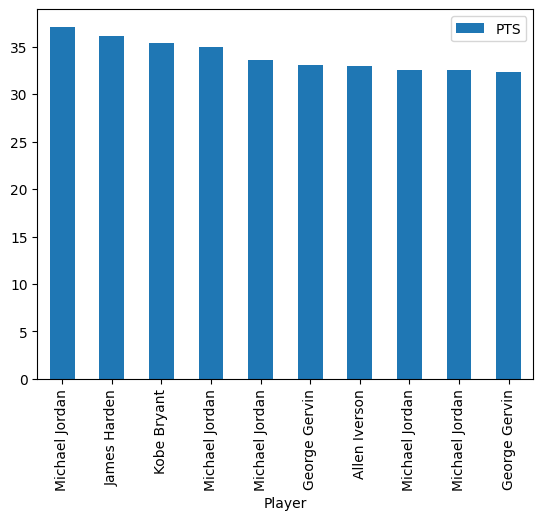

In [51]:
highest_scorers.plot.bar("Player","PTS")

In [52]:
numeric_cols = stats.select_dtypes(include=[np.number])
numeric_cols.corr()["Share"]

Age        0.018000
G          0.094218
GS         0.171749
MP         0.162840
FG         0.268222
FGA        0.242259
FG%        0.065023
3P         0.073919
3PA        0.074713
3P%        0.026297
2P         0.268230
2PA        0.244862
2P%        0.058025
eFG%       0.056378
FT         0.312899
FTA        0.313211
FT%        0.043689
ORB        0.117303
DRB        0.217546
TRB        0.194710
AST        0.198684
STL        0.176474
BLK        0.148523
TOV        0.227006
PF         0.073628
PTS        0.281009
Year      -0.015623
Pts Won    0.983993
Pts Max    0.515907
Share      1.000000
W          0.120460
L         -0.119270
W/L%       0.123039
GB        -0.098662
PS/G       0.038124
PA/G      -0.033154
SRS        0.116820
Name: Share, dtype: float64